In [104]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [105]:
def get_train_data():
    file = "./data/train_90.csv"
    train_data = pd.read_csv(file)
    return train_data

def get_test_data():
    file = "./data/A榜/node_test_4_A.csv"
    test_data = pd.read_csv(file)
    return test_data

In [106]:
d = get_train_data()
print(d.head())

  geohash_id   date_id    F_1    F_2    F_3    F_4    F_5    F_6    F_7  \
0  4885e281g  20230104 -0.711 -0.696 -0.794 -0.727 -0.747 -0.792  1.539   
1  4885e281g  20230105 -0.909 -0.903 -0.947 -0.844 -0.856 -0.908 -0.371   
2  4885e281g  20230106 -0.920 -0.925 -0.923 -0.852 -0.853 -0.915 -0.334   
3  4885e281g  20230107 -0.926 -0.931 -0.943 -0.837 -0.850 -0.907 -0.993   
4  4885e281g  20230108 -0.750 -0.764 -0.818 -0.749 -0.764 -0.816  1.116   

     F_8  ...   F_28   F_29   F_30   F_31   F_32   F_33   F_34   F_35  \
0  2.433  ...  0.073  0.344  0.006 -0.446 -0.502 -0.456 -0.457 -0.830   
1  0.990  ...  0.055  0.298  0.007 -0.523 -0.558 -0.533  0.113 -0.887   
2  0.792  ...  0.067  0.324  0.006 -0.535 -0.564 -0.540  0.367 -1.021   
3 -0.006  ...  0.076  0.276  0.010 -0.534 -0.554 -0.521  0.550 -0.211   
4  1.447  ...  0.079  0.328  0.008 -0.468 -0.500 -0.419 -0.236  0.644   

   active_index  consume_index  
0        69.306          63.78  
1        68.881          61.62  
2        69

In [107]:
# 无缺失值
for col in d.columns:
    unique_values = d[col].unique()
    has_missing_values = any(pd.isnull(unique_values))
    print(f"{col} : Missing Values: {has_missing_values}")

geohash_id : Missing Values: False
date_id : Missing Values: False
F_1 : Missing Values: False
F_2 : Missing Values: False
F_3 : Missing Values: False
F_4 : Missing Values: False
F_5 : Missing Values: False
F_6 : Missing Values: False
F_7 : Missing Values: False
F_8 : Missing Values: False
F_9 : Missing Values: False
F_10 : Missing Values: False
F_11 : Missing Values: False
F_12 : Missing Values: False
F_13 : Missing Values: False
F_14 : Missing Values: False
F_15 : Missing Values: False
F_16 : Missing Values: False
F_17 : Missing Values: False
F_18 : Missing Values: False
F_19 : Missing Values: False
F_20 : Missing Values: False
F_21 : Missing Values: False
F_22 : Missing Values: False
F_23 : Missing Values: False
F_24 : Missing Values: False
F_25 : Missing Values: False
F_26 : Missing Values: False
F_27 : Missing Values: False
F_28 : Missing Values: False
F_29 : Missing Values: False
F_30 : Missing Values: False
F_31 : Missing Values: False
F_32 : Missing Values: False
F_33 : Missing

In [108]:
# 方差
feature_std = d.std().sort_values(ascending=1)
print(feature_std.head(20))

F_27    0.000000
F_23    0.000000
F_30    0.008622
F_26    0.029539
F_28    0.033918
F_29    0.052436
F_24    0.053863
F_25    0.055250
F_22    0.064357
F_20    0.077634
F_21    0.081984
F_19    0.291357
F_34    0.758209
F_32    0.812070
F_31    0.893787
F_3     0.959431
F_10    0.966786
F_5     0.975154
F_4     0.975956
F_2     0.979107
dtype: float64


C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\891375946.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_std = d.std().sort_values(ascending=1)


In [109]:
# 剔除标准差几乎为零的特征项
threshold = 0.1
columns_to_drop = feature_std[(feature_std < threshold) & (feature_std.index != 'target')].index
d.drop(columns_to_drop, axis=1, inplace=True)

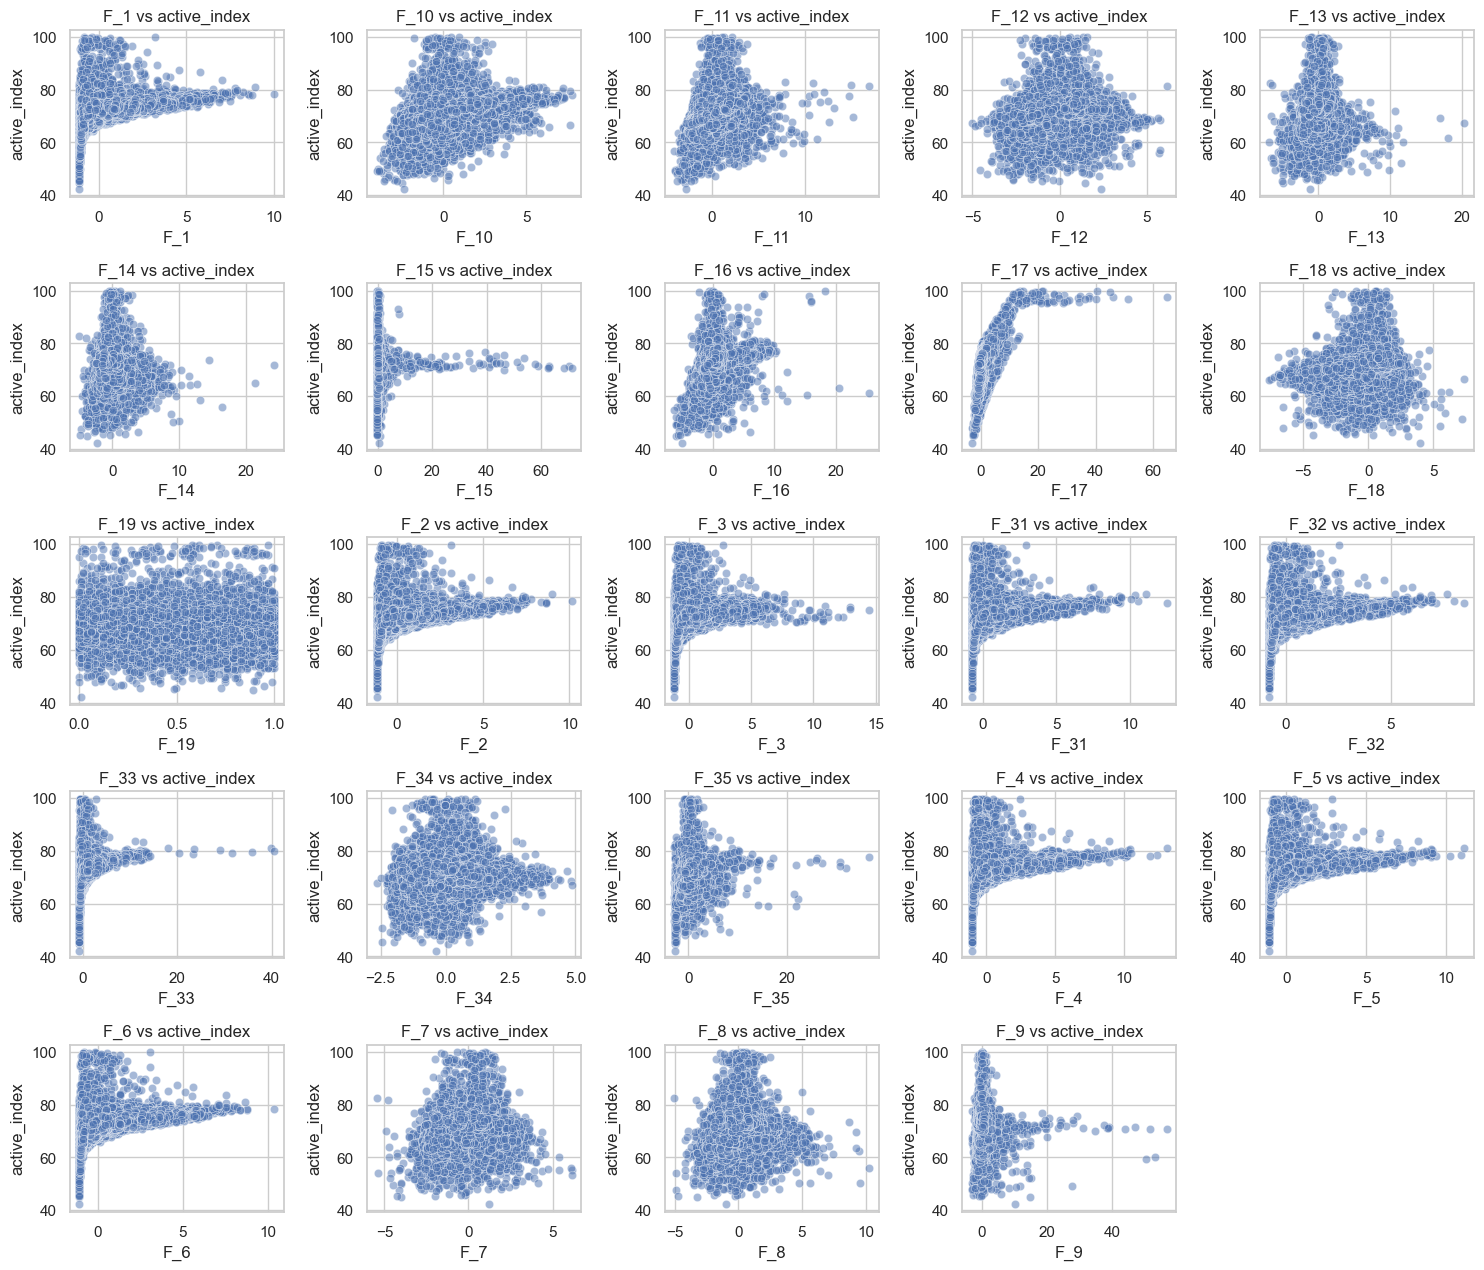

In [110]:
# 特征关于 active_index 分布
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))

features = d.columns.difference(['geohash_id', 'date_id', 'active_index', 'consume_index'])

for i, feature in enumerate(features, 1):
    plt.subplot(8, 5, i)
    sns.scatterplot(x=d[feature], y=d['active_index'], alpha=0.5)
    plt.title(f"{feature} vs active_index")

plt.tight_layout()
plt.show()

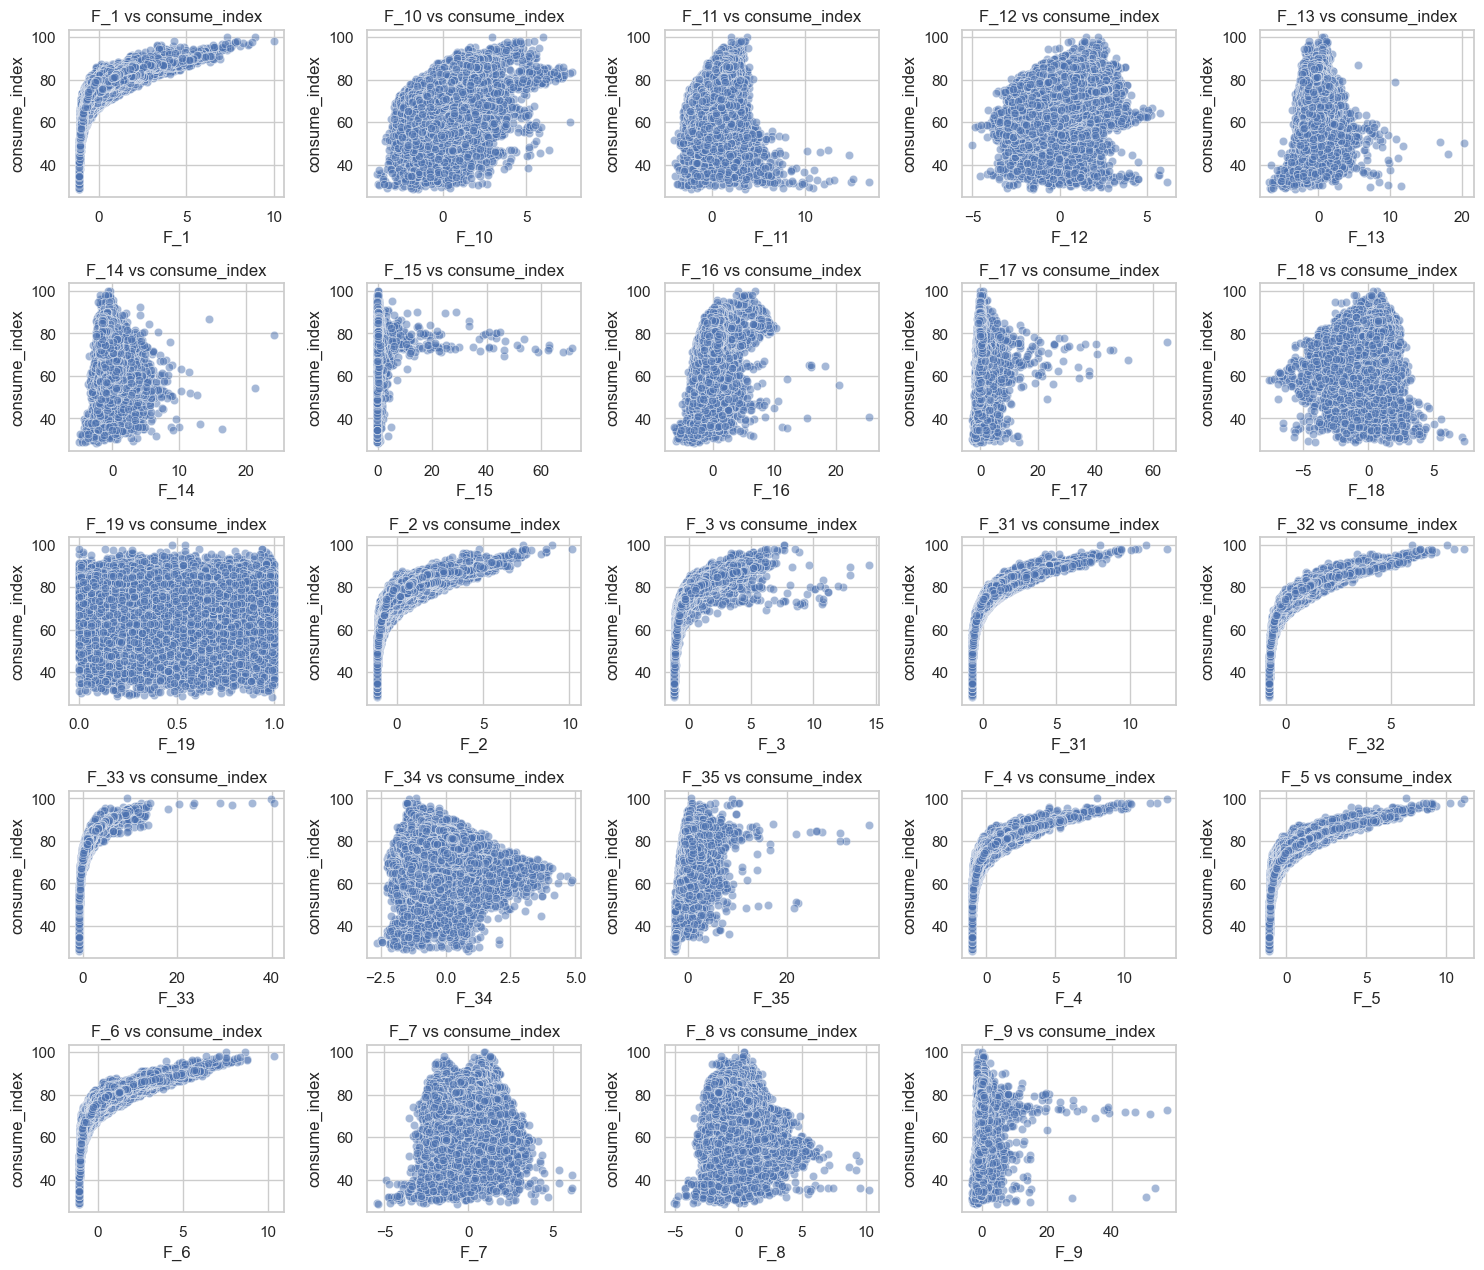

In [111]:
# 特征关于 consume_index 分布
sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))

features = d.columns.difference(['geohash_id', 'date_id', 'active_index', 'consume_index'])

for i, feature in enumerate(features, 1):
    plt.subplot(8, 5, i)
    sns.scatterplot(x=d[feature], y=d['consume_index'], alpha=0.5)
    plt.title(f"{feature} vs consume_index")

plt.tight_layout()
plt.show()

In [112]:
# 相关系数 selectKBest
features = d.columns.difference(['geohash_id', 'date_id', 'active_index', 'consume_index'])
correlations_active_index = d[features].corrwith(d['active_index'])
correlations_consume_index = d[features].corrwith(d['consume_index'])
correlations = (correlations_active_index + correlations_consume_index) / 2

print(correlations.head(20))

threshold = 0.1

selected_features_index = correlations_active_index[abs(correlations) >= threshold].index
d_filtered = d[selected_features_index.union(['geohash_id', 'date_id', 'active_index'])]

print(d_filtered.shape)
print(d_filtered.columns)

F_1     0.703917
F_10    0.363948
F_11    0.254425
F_12    0.328102
F_13    0.033793
F_14   -0.224359
F_15    0.068942
F_16    0.363352
F_17    0.177565
F_18    0.228639
F_19    0.002212
F_2     0.719579
F_3     0.710143
F_31    0.717210
F_32    0.744683
F_33    0.670977
F_34    0.047521
F_35    0.384023
F_4     0.714485
F_5     0.724756
dtype: float64
(102600, 21)
Index(['F_1', 'F_10', 'F_11', 'F_12', 'F_14', 'F_16', 'F_17', 'F_18', 'F_2',
       'F_3', 'F_31', 'F_32', 'F_33', 'F_35', 'F_4', 'F_5', 'F_6', 'F_8',
       'active_index', 'date_id', 'geohash_id'],
      dtype='object')


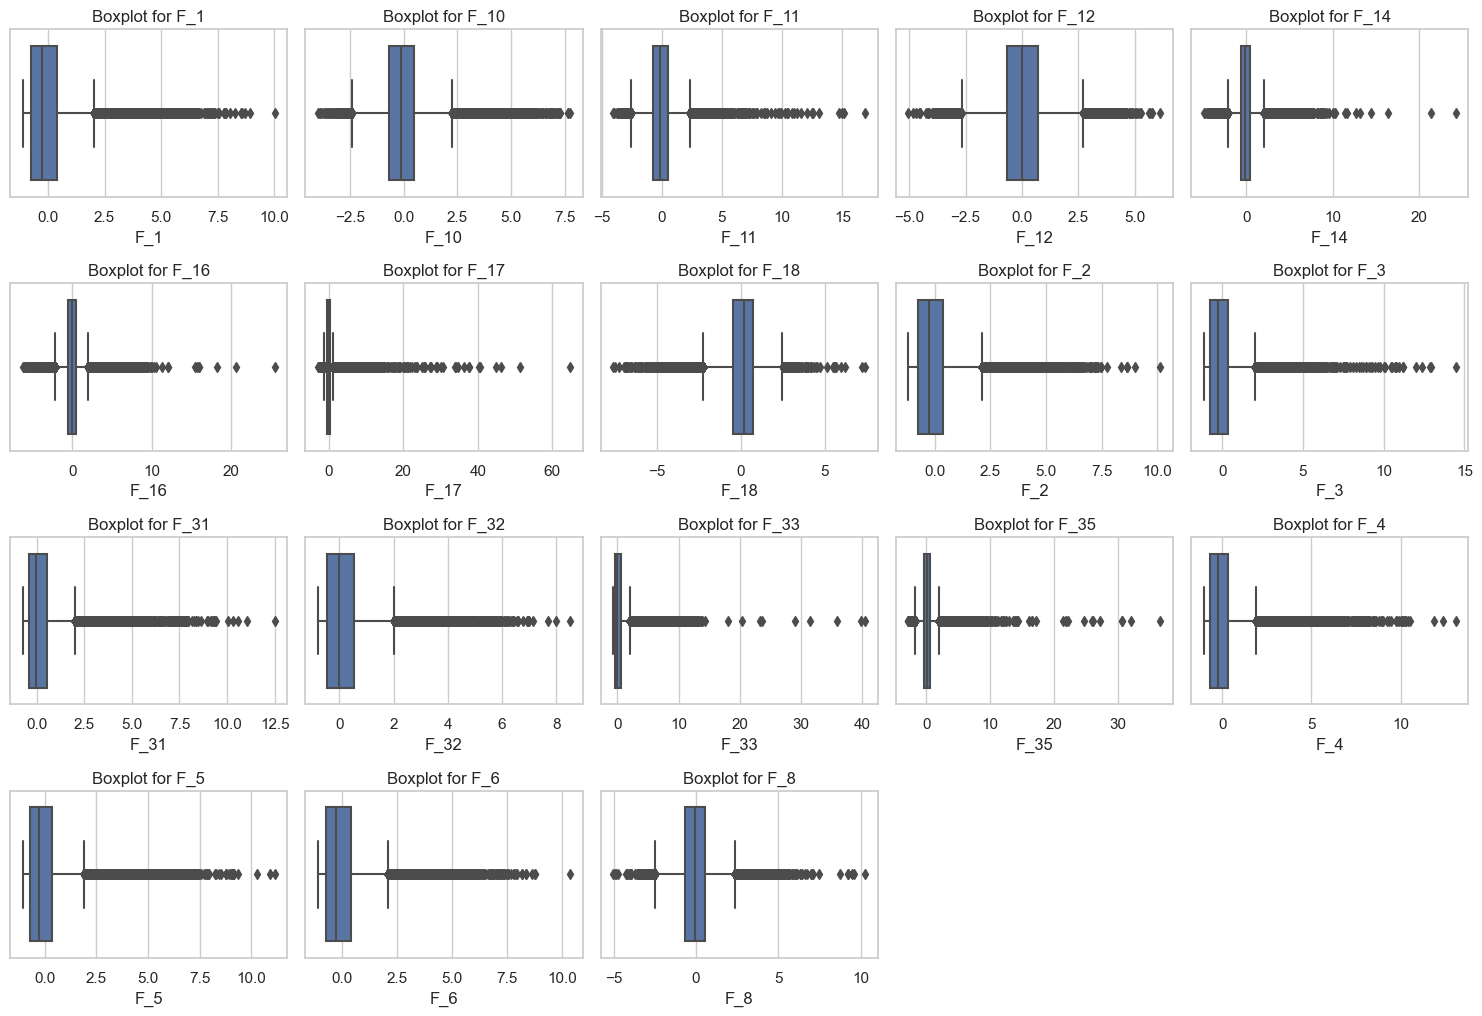

In [113]:
# 异常值分析
import matplotlib.pyplot as plt
import seaborn as sns

features = d_filtered.columns.difference(['geohash_id', 'date_id', 'active_index', 'consume_index'])
sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))

for i, feature in enumerate(features, 1):
    plt.subplot(8, 5, i)
    sns.boxplot(x=d_filtered[feature])
    plt.title(f"Boxplot for {feature}")

plt.tight_layout()
plt.show()

In [114]:
# 3σ原则剔除异常值
features = d_filtered.columns.difference(['geohash_id', 'date_id', 'active_index', 'consume_index'])

for feature in features:
    mean_value = d_filtered[feature].mean()
    std_value = d_filtered[feature].std()

    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value

    d_filtered[feature] = d_filtered[feature].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

print(d_filtered.shape)
print(d_filtered.columns)

C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\2722011597.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered[feature] = d_filtered[feature].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)


(102600, 21)
Index(['F_1', 'F_10', 'F_11', 'F_12', 'F_14', 'F_16', 'F_17', 'F_18', 'F_2',
       'F_3', 'F_31', 'F_32', 'F_33', 'F_35', 'F_4', 'F_5', 'F_6', 'F_8',
       'active_index', 'date_id', 'geohash_id'],
      dtype='object')


In [115]:
# 是否归一化
from sklearn.preprocessing import MinMaxScaler, StandardScaler

is_std = 1
if is_std:
    scaler = StandardScaler()  # MinMaxScaler()
    d_filtered[features] = scaler.fit_transform(d_filtered[features])

# 打印归一化后的数据
print(d_filtered.head())


        F_1      F_10      F_11      F_12      F_14      F_16      F_17  \
0 -0.762051  1.557667  1.233715  0.530771  3.147055  0.782207  0.606519   
1 -1.005120  0.632710  0.692939 -0.526219  1.991165 -0.358159  0.757474   
2 -1.018624  0.468348  1.012539 -0.648575  2.774301  0.202915  1.349005   
3 -1.025990  0.532959  0.545857 -0.841877  0.615385  0.501670  0.481894   
4 -0.809928  1.154132  1.013645  0.071166  1.473777  0.736058  0.724123   

       F_18       F_2       F_3  ...      F_32      F_33      F_35       F_4  \
0  0.076091 -0.737072 -0.862718  ... -0.897408 -0.829633 -1.092549 -0.810223   
1 -0.653455 -0.987720 -1.053456  ... -0.978440 -0.928897 -1.162806 -0.961036   
2 -0.802479 -1.014359 -1.023536  ... -0.987123 -0.937921 -1.327971 -0.971347   
3 -0.782461 -1.021624 -1.048469  ... -0.972652 -0.913427 -0.329586 -0.952013   
4 -0.127426 -0.819410 -0.892638  ... -0.894514 -0.781934  0.724264 -0.838581   

        F_5       F_6       F_8  active_index   date_id  geohash_id 

C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\2585468686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered[features] = scaler.fit_transform(d_filtered[features])


In [116]:
# 特征较少 可能需要升维
# 年份相同，将月日单独出来
date = pd.to_datetime(d_filtered['date_id'].astype(str))

# 提取时间序列特征，例如年、月、日、星期等
# d_filtered['year'] = date.dt.year
d_filtered['month'] = date.dt.month
d_filtered['day'] = date.dt.day
d_filtered['is_weekday'] = (date.dt.weekday < 5).astype(int)

print(d_filtered.shape)
print(d_filtered.columns)

(102600, 24)
Index(['F_1', 'F_10', 'F_11', 'F_12', 'F_14', 'F_16', 'F_17', 'F_18', 'F_2',
       'F_3', 'F_31', 'F_32', 'F_33', 'F_35', 'F_4', 'F_5', 'F_6', 'F_8',
       'active_index', 'date_id', 'geohash_id', 'month', 'day', 'is_weekday'],
      dtype='object')


C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\1800168382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['month'] = date.dt.month
C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\1800168382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['day'] = date.dt.day
C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_3404\1800168382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [118]:
print(d_filtered['is_weekday'].unique())
print(d_filtered['day'].unique())
print(d_filtered['month'].unique())

[1 0]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31  1  2  3]
[1 2 3 4]


In [120]:
# 多项式特征升维
from sklearn.preprocessing import PolynomialFeatures

selected_features = ['F_10']

X_poly_features = d_filtered[selected_features]

poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X_poly_features)

d_filtered_poly = pd.concat([d_filtered, pd.DataFrame(X_poly, columns=poly.get_feature_names_out(selected_features))], axis=1)

In [122]:
print(d_filtered_poly.columns)
print(d_filtered.columns)

Index(['F_1', 'F_10', 'F_11', 'F_12', 'F_14', 'F_16', 'F_17', 'F_18', 'F_2',
       'F_3', 'F_31', 'F_32', 'F_33', 'F_35', 'F_4', 'F_5', 'F_6', 'F_8',
       'active_index', 'date_id', 'geohash_id', 'month', 'day', 'is_weekday',
       'F_10', 'F_10^2', 'F_10^3', 'F_10^4', 'F_10^5', 'F_10^6', 'F_10^7',
       'F_10^8', 'F_10^9', 'F_10^10'],
      dtype='object')
Index(['F_1', 'F_10', 'F_11', 'F_12', 'F_14', 'F_16', 'F_17', 'F_18', 'F_2',
       'F_3', 'F_31', 'F_32', 'F_33', 'F_35', 'F_4', 'F_5', 'F_6', 'F_8',
       'active_index', 'date_id', 'geohash_id', 'month', 'day', 'is_weekday'],
      dtype='object')


In [123]:
print(d_filtered.shape)

(102600, 24)
